## Comparison of different implementations of InfoNCE loss

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

batch_size = 5
input_dim = 10
hidden_dim = 5
embedding_dim = 3

# Generate some random data
query = torch.randn(batch_size, input_dim, requires_grad=True)
positive_key = torch.randn(batch_size, input_dim, requires_grad=True)
negative_key = torch.randn(batch_size, input_dim, requires_grad=True)

#### PyTorch implementation of the InfoNCE loss from ["Representation Learning with Contrastive Predictive Coding"](<https://arxiv.org/abs/1807.03748>).  
[Github code](https://github.com/RElbers/info-nce-pytorch/blob/main/info_nce/__init__.py)

In [2]:
import torch
import torch.nn.functional as F
from torch import nn

def info_nce(query, positive_key, negative_keys=None, temperature=0.1, reduction='mean', negative_mode='unpaired'):
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    if negative_keys is not None:
        # Explicit negative keys

        # Cosine between positive pairs
        positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)

        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            negative_logits = query @ transpose(negative_keys)

        elif negative_mode == 'paired':
            query = query.unsqueeze(1)
            negative_logits = query @ transpose(negative_keys)
            negative_logits = negative_logits.squeeze(1)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        logits = query @ transpose(positive_key)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)


def transpose(x):
    return x.transpose(-2, -1)


def normalize(*xs):
    return [None if x is None else F.normalize(x, dim=-1) for x in xs]

In [3]:
from info_nce import InfoNCE

# Define a simple fully connected neural network
class SimpleFCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, optimizer
model = SimpleFCNN(input_dim, hidden_dim, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize InfoNCE loss
loss_fn = InfoNCE(negative_mode='unpaired')

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    query_out = model(query)
    positive_key_out = model(positive_key)
    negative_key_out = model(negative_key)
    
    loss = loss_fn(query_out, positive_key_out, negative_key_out)
    loss.backward()
    optimizer.step()
    
    if epoch%1==0 or epoch==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

Epoch [1/5], Loss: 1.6766
Epoch [2/5], Loss: 1.3608
Epoch [3/5], Loss: 1.2239
Epoch [4/5], Loss: 1.1187
Epoch [5/5], Loss: 1.0261
Training complete.


#### Changing negative logits of pytorch implementation to sum of element-wise multiplication

In [4]:
import torch
import torch.nn.functional as F
from torch import nn

def info_nce_ele(query, positive_key, negative_keys=None, temperature=0.1, reduction='mean', negative_mode='unpaired'):
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    # print(f"query : {query.shape}")
    # print(f"pos key: {positive_key.shape}")
    
    query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    if negative_keys is not None:
        # Explicit negative keys

        # Cosine between positive pairs
        positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)

        # print(f"ele : {(query * positive_key).shape}")
        # print(f"pos logit: {positive_logit.shape}")

        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            # negative_logits = query @ transpose(negative_keys)
            negative_logits = torch.sum(query * negative_keys, dim=1, keepdim=True)
            # print(f"neg key: {negative_keys.shape}")
            # print(f"neg logit: {negative_logits.shape}")

        elif negative_mode == 'paired':
            query = query.unsqueeze(1)
            negative_logits = query @ transpose(negative_keys)
            negative_logits = negative_logits.squeeze(1)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
        # print(logits.shape)
        # print(labels)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        logits = query @ transpose(positive_key)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)
    
    # print(labels)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)

def transpose(x):
    return x.transpose(-2, -1)


def normalize(*xs):
    return [None if x is None else F.normalize(x, dim=-1) for x in xs]

In [5]:
# Define a simple fully connected neural network
class SimpleFCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, optimizer
batch_size = 5
input_dim = 10
hidden_dim = 5
embedding_dim = 3

model = SimpleFCNN(input_dim, hidden_dim, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    query_out = model(query)
    positive_key_out = model(positive_key)
    negative_key_out = model(negative_key)
    
    loss = info_nce_ele(query_out, positive_key_out, negative_key_out)
    loss.backward()
    optimizer.step()
    
    if epoch%1==0 or epoch==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

Epoch [1/5], Loss: 0.7098
Epoch [2/5], Loss: 0.5111
Epoch [3/5], Loss: 0.4000
Epoch [4/5], Loss: 0.3163
Epoch [5/5], Loss: 0.2427
Training complete.


#### InfoNCE loss implemented in this [blog](https://medium.com/@_prinsh_u/why-use-infonce-loss-in-self-supervised-learning-1318b98f001b)

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

class InfoNCE_blog(nn.Module):
    def __init__(self, temperature, device):
        super().__init__()
        self.temperature = temperature
        self.device = device

    def forward(self, query, pos, neg):
        '''
        Use other samples in batch as negative samples.
        query, pos, neg : [B, E]
        where B is a batch_size, E is an embedding size
        '''
        # Normalize
        query = F.normalize(query, dim=-1)
        pos = F.normalize(pos, dim=-1)
        neg = F.normalize(neg, dim=-1)
        
        # Compute cosine similarity locally
        logits_pos = query @ pos.T
        logits_neg = query @ neg.T
        
        # Concatenate logits
        logits = torch.cat((logits_pos, logits_neg), dim=1)
        
        # Generate labels
        local_batch_size = query.shape[0]
        labels = torch.arange(local_batch_size).to(self.device)
        
        # Cross-entropy loss
        loss = F.cross_entropy(logits / self.temperature, labels, reduction='mean')

        return loss
    
nce_loss = InfoNCE_blog(0.1, torch.device('cpu'))

In [7]:
# Define a simple fully connected neural network
class SimpleFCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, optimizer
model = SimpleFCNN(input_dim, hidden_dim, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize InfoNCE loss
loss_fn = InfoNCE_blog(0.1, torch.device('cpu'))

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    query_out = model(query)
    positive_key_out = model(positive_key)
    negative_key_out = model(negative_key)
    
    loss = loss_fn(query_out, positive_key_out, negative_key_out)
    loss.backward()
    optimizer.step()
    
    if epoch%1==0 or epoch==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

Epoch [1/5], Loss: 3.5862
Epoch [2/5], Loss: 2.8968
Epoch [3/5], Loss: 2.4033
Epoch [4/5], Loss: 2.0153
Epoch [5/5], Loss: 1.7250
Training complete.


#### 2D plots of embeddings of dimension 2

In [8]:
import matplotlib.pyplot as plt

def plot_2d(query_out, positive_key_out, negative_key_out):
    # Set up the plot
    plt.figure()

    for ten in query_out:
        ten = ten.detach().numpy()
        plt.quiver(0, 0, ten[0], ten[1], angles='xy', scale_units='xy', scale=1, color='r', label='query')

    for ten in positive_key_out:
        ten = ten.detach().numpy()
        plt.quiver(0, 0, ten[0], ten[1], angles='xy', scale_units='xy', scale=1, color='b', label='positive')

    for ten in negative_key_out:
        ten = ten.detach().numpy()
        plt.quiver(0, 0, ten[0], ten[1], angles='xy', scale_units='xy', scale=1, color='g', label='negative')

    # Set the plot limits
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    plt.legend()
    plt.title('2D Vector Visualization')

    # Show the plot
    plt.show()

Epoch [1/5], Loss: 3.6568


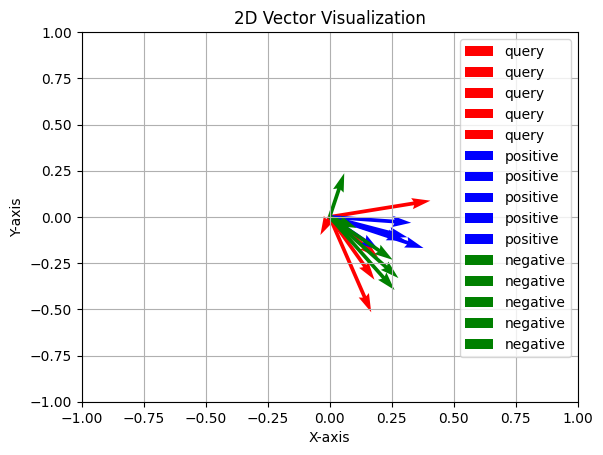

Epoch [2/5], Loss: 2.7208


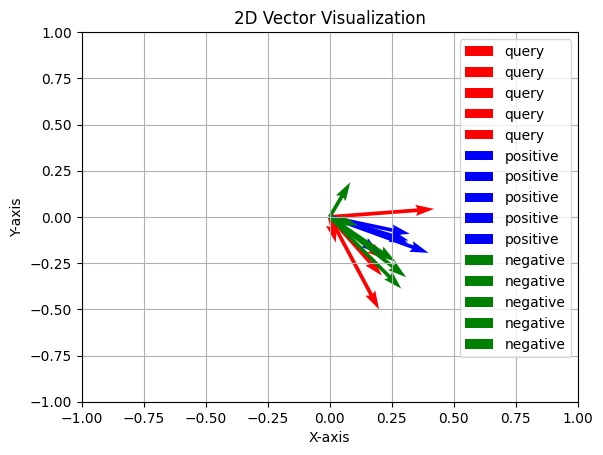

Epoch [3/5], Loss: 2.1986


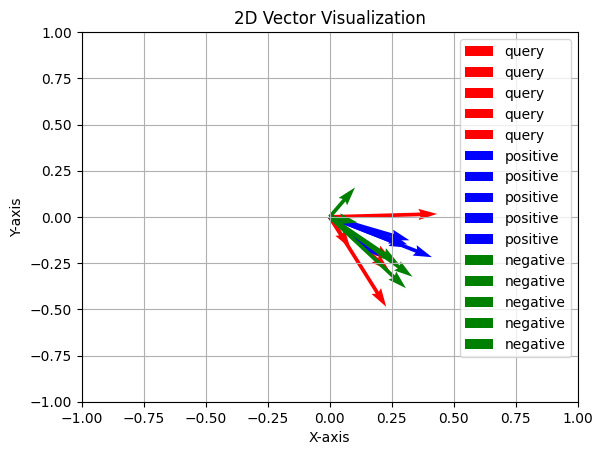

Epoch [4/5], Loss: 1.9641


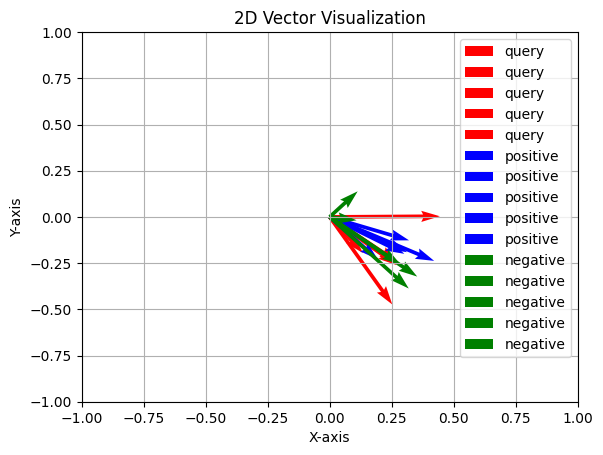

Epoch [5/5], Loss: 1.8508


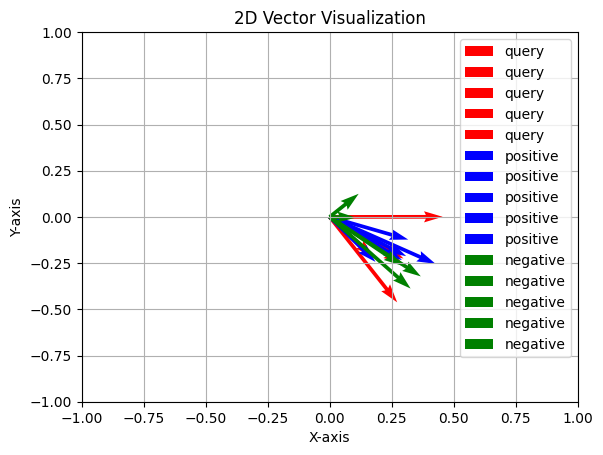

Training complete.


In [9]:
batch_size = 5
input_dim = 10
hidden_dim = 5
embedding_dim = 2 # set as 2 for 2d plot

# Generate some random data
query = torch.randn(batch_size, input_dim, requires_grad=True)
positive_key = torch.randn(batch_size, input_dim, requires_grad=True)
negative_key = torch.randn(batch_size, input_dim, requires_grad=True)

# Define a simple fully connected neural network
class SimpleFCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, optimizer
model = SimpleFCNN(input_dim, hidden_dim, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize InfoNCE loss
# change as per your choice
loss_fn = InfoNCE_blog(0.1, torch.device('cpu'))

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    query_out = model(query)
    positive_key_out = model(positive_key)
    negative_key_out = model(negative_key)
    
    loss = loss_fn(query_out, positive_key_out, negative_key_out)
    loss.backward()
    optimizer.step()
    
    if epoch%1==0 or epoch==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        plot_2d(query_out, positive_key_out, negative_key_out)

print('Training complete.')